In [1]:
import geopandas as gpd
import random
from shapely.geometry import Point, Polygon
import numpy as np
import os
import zipfile
from math import pi, sin, cos, sqrt
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

# FUNCTION TO CALCULATE THE AREA OF COUNTRIES WITH SMALL SIZES USING THE GADM ISO NAMING CODES

In [2]:
# Define constants
MIN_SAMPLE_POINTS = 10
MAX_SAMPLE_POINTS = 100
THRESHOLD_AREA = 1e5  # km^2

GADM_URL = 'https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_{}_shp.zip'


def get_country_shapefile(country_name):
    """Download and extract the shapefile for a given country."""
    country_code = country_name.upper()[:3]  # ISO 3166-1 alpha-3 code
    url = GADM_URL.format(country_code)
    filename = os.path.basename(url)
    foldername = os.path.splitext(filename)[0]
    if not os.path.exists(foldername):
        print(f'Downloading {filename}...')
        urlretrieve(url, filename)
        print(f'Extracting {filename}...')
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(foldername)
    return foldername


def get_land_area(polygons):
    """Calculate the land area of a GeoDataFrame of polygons."""
    projected = polygons.to_crs(epsg=3857)
    return projected.geometry.area.sum() / 1e6  # km^2



def generate_sample_points(polygons, num_points):
    """Generate random sample points within the bounds of a GeoDataFrame of polygons."""
    min_lon, min_lat, max_lon, max_lat = polygons.total_bounds
    points = []
    while len(points) < num_points:
        lon, lat = random.uniform(min_lon, max_lon), random.uniform(min_lat, max_lat)
        point = (lon, lat)
        if polygons.contains(gpd.points_from_xy([lon], [lat])).any():
            points.append(point)
    return points


def estimate_land_area(polygons):
    """Estimate the land area of a GeoDataFrame of polygons using the Monte Carlo method."""
    land_area = get_land_area(polygons)
    if land_area < THRESHOLD_AREA:
        return land_area  # Direct calculation for small areas
    elif land_area < 10 * THRESHOLD_AREA:
        num_points = MIN_SAMPLE_POINTS
    else:
        num_points = MAX_SAMPLE_POINTS
    points = generate_sample_points(polygons, num_points)
    land_points = sum(1 for lon, lat in points if polygons.contains(gpd.points_from_xy([lon], [lat])).any())
    area_factor = land_points / num_points
    return land_area / area_factor





Enter the name of a country: SYC
The estimated land area of SYC is 502.28 km^2


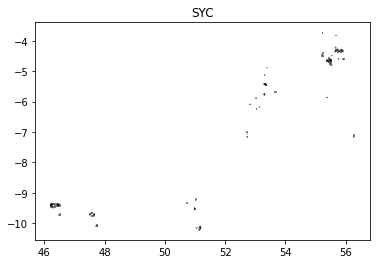

In [3]:
def main():
    # Get country name input from user
    country_name = input('Enter the name of a country: ')

    # Download and extract shapefile for the country
    foldername = get_country_shapefile(country_name)

    # Read polygons from shapefile and calculate land area
    polygons = gpd.read_file(foldername)
    land_area = estimate_land_area(polygons)

    # Display results
    print(f'The estimated land area of {country_name} is {land_area:.2f} km^2')
    ax = polygons.plot(alpha=0.5, edgecolor='black')
    ax.set_title(country_name)
    plt.show()


if __name__ == '__main__':
    main()

# FUNCTION TO CALCULATE THE AREA OF COUNTRIES WITH BOTH SMALL AND VERY LARGE SIZES USING THE GADM ISO NAMING CODES 

In [4]:
# Define constants
MIN_SAMPLE_POINTS = 10
MAX_SAMPLE_POINTS = 100
THRESHOLD_AREA = 1e10  # km^2


GADM_URL = 'https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_{}_shp.zip'


def get_country_shapefile(country_name):
    """Download and extract the shapefile for a given country."""
    country_code = country_name.upper()[:3]  # ISO 3166-1 alpha-3 code
    url = GADM_URL.format(country_code)
    filename = os.path.basename(url)
    foldername = os.path.splitext(filename)[0]
    if not os.path.exists(foldername):
        print(f'Downloading {filename}...')
        urlretrieve(url, filename)
        print(f'Extracting {filename}...')
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(foldername)
    return foldername


def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between two points on the surface of the sphere."""
    delta_lon = lon2 - lon1
    cos_lat1 = cos(lat1)
    sin_lat1 = sin(lat1)
    cos_lat2 = cos(lat2)
    sin_lat2 = sin(lat2)
    delta_sigma = atan2(sqrt((cos_lat2 * sin(delta_lon)) ** 2 + (cos_lat1 * sin_lat2 - sin_lat1 * cos_lat2 * cos(delta_lon)) ** 2),
                        sin_lat1 * sin_lat2 + cos_lat1 * cos_lat2 * cos(delta_lon))
    return delta_sigma


def calculate_triangle_spherical_excess(lon1, lat1, lon2, lat2, lon3, lat3):
    """Calculate the spherical excess of a triangle on the surface of the sphere."""
    a = great_circle_distance(lon1, lat1, lon2, lat2)
    b = great_circle_distance(lon2, lat2, lon3, lat3)
    c = great_circle_distance(lon3, lat3, lon1, lat1)
    s = (a + b + c) / 2
    return 2 * atan2(sqrt(abs(s * (s - a) * (s - b) * (s - c))), sqrt((s - a) * (s - b) * (s - c) * s))


def calculate_polygon_spherical_excess(polygons):
    """Calculate the spherical excess of a GeoDataFrame of polygons."""
    projected = polygons.to_crs(epsg=4326)
    spherical_excess = 0
    for polygon in projected.geometry:
        if polygon.geom_type == 'Polygon':
            spherical_excess += calculate_polygon_spherical_excess(polygon)
        elif polygon.geom_type == 'MultiPolygon':
            for subpolygon in polygon:
                spherical_excess += calculate_polygon_spherical_excess(subpolygon)
    return spherical_excess


# define the function to estimate the land_area
def estimate_land_area(polygons):
    """Estimate the land area of a GeoDataFrame of polygons using the Monte Carlo method."""
    land_area = get_land_area(polygons)
    if land_area < THRESHOLD_AREA:
        return land_area  # Direct calculation for small areas
    elif land_area < 10 * THRESHOLD_AREA:
        num_points = MIN_SAMPLE_POINTS
    else:
        num_points = MAX_SAMPLE_POINTS
    points = generate_sample_points(polygons, num_points)
    land_points = sum(1 for lon, lat in points if polygons.contains(gpd.points_from_xy([lon], [lat])).any())
    area_factor = land_points / num_points
    return land_area / area_factor

#main method


Enter the name of a country: KEN
The estimated land area of KEN is 590855.83 km^2


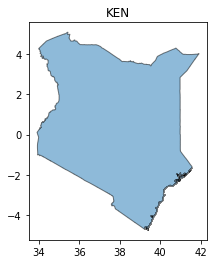

In [5]:
def main():
    # Get country name input from user
    country_name = input('Enter the name of a country: ')

    # Download and extract shapefile for the country
    foldername = get_country_shapefile(country_name)

    # Read polygons from shapefile and calculate land area
    polygons = gpd.read_file(foldername)
    land_area = estimate_land_area(polygons)

    # Display results
    print(f'The estimated land area of {country_name} is {land_area:.2f} km^2')
    ax = polygons.plot(alpha=0.5, edgecolor='black')
    ax.set_title(country_name)
    plt.show()

if __name__ == '__main__':
    main()